In [1]:
%load_ext pretty_jupyter

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from datetime import date
import hisepy
import numpy as np
import os
import pandas as pd
import re
import scanpy as sc

## Helper functions

In [3]:
def cache_uuid_path(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    if not os.path.isdir(cache_path):
        hise_res = hisepy.reader.cache_files([uuid])
    filename = os.listdir(cache_path)[0]
    cache_file = '{p}/{f}'.format(p = cache_path, f = filename)
    return cache_file

In [4]:
def read_csv_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_csv(cache_file)
    return res

In [5]:
def read_parquet_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_parquet(cache_file)
    return res

In [6]:
def read_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file)
    return res

In [7]:
def backed_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file, backed = 'r')
    return res

In [8]:
def rm_cache_uuid(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    rm_call = 'rm -r {d}'.format(d = cache_path)
    os.system(rm_call)

In [9]:
def format_cell_type(cell_type):
    cell_type = re.sub('\\+', 'pos', cell_type)
    cell_type = re.sub('-', 'neg', cell_type)
    cell_type = re.sub(' ', '_', cell_type)
    return cell_type

In [10]:
def filename_cell_type(filename):
    cell_type = re.sub('.+L3_','',filename)
    cell_type = re.sub('_2024.+','',cell_type)
    cell_type = re.sub('_', ' ', cell_type)
    cell_type = re.sub('pos','+', cell_type)
    cell_type = re.sub('neg','-', cell_type)
    return cell_type

In [11]:
def add_labels(adata, labels):
    obs = adata.obs
    obs = obs.reset_index(drop = True)
    obs = obs.merge(labels, on = 'barcodes', how = 'left')
    obs = obs.set_index('barcodes', drop = False)
    adata.obs = obs
    return adata

In [12]:
def element_id(n = 3):
    import periodictable
    from random import randrange
    rand_el = []
    for i in range(n):
        el = randrange(0,118)
        rand_el.append(periodictable.elements[el].name)
    rand_str = '-'.join(rand_el)
    return rand_str

## Read previous, non-tracked labels
We ran a preliminary analysis of our dataset that wasn't tracked for reproducibility. Here, we'll retrieve the labels for visualization and comparison to check for consistency.

In [13]:
original_uuid = '3868592c-0087-4ed8-98b2-4bf1b8676111'
original_df = read_parquet_uuid(original_uuid)
original_df = original_df[['barcodes', 'AIFI_L1', 'AIFI_L2', 'AIFI_L3']]
original_df = original_df.rename({'AIFI_L1': 'original_L1', 'AIFI_L2': 'original_L2', 'AIFI_L3': 'original_L3'}, axis = 1)

In [14]:
original_df.head()

barcodes original_L1 original_L2 original_L3
0  05ea9806794211eb93b836d1cb6129eb          DC        cDC1        cDC1
1  e225c914794011eb9282e2ceeb91ba52          DC        cDC1        cDC1
2  b1379eae795411eb958b0245821e6993          DC        cDC1        cDC1
3  b13d3a8a795411eb958b0245821e6993          DC        cDC1        cDC1
4  b1430d16795411eb958b0245821e6993          DC        cDC1        cDC1

## Markers for dotplots

In [15]:
broad_markers = [
    'CD3D', # T cells
    'CD3E', # T cells/NK
    'FCN1', # Monocytes/Myeloid
    'HBB', # Erythrocytes
    'IL7R', # T cells
    'MS4A1', # B cells
    'CD79A', # B cells
    'PPBP', # Platelets
    'IFI44L' # ISG-high
]

In [16]:
class_markers = [
    'CD44'
]

## Read cell type hierarchy

In [17]:
hierarchy_uuid = '1a44252c-8cab-4c8f-92c9-d8f3af633790'
hierarchy_df = read_csv_uuid(hierarchy_uuid)

## Identify files for use in HISE

In [18]:
search_id = 'calcium-krypton-hydrogen'

Retrieve files stored in our HISE project store

In [19]:
ps_df = hisepy.list_files_in_project_store('cohorts')
ps_df = ps_df[['id', 'name']]

Filter for files from the previous notebook using our search_id

In [20]:
search_df = ps_df[ps_df['name'].str.contains(search_id)]
search_df = search_df.sort_values('name')
search_df['AIFI_L3'] = [filename_cell_type(f) for f in search_df['name']]

In [21]:
search_df['AIFI_L3'].tolist()

['BaEoMaP cell', 'CLP cell', 'CMP cell', 'Erythrocyte', 'Platelet']

## Review BaEoMaP cell

In [22]:
cell_type = 'BaEoMaP cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [23]:
type_uuid

'03706635-e35d-4fd5-b25b-b8dae718e35d'

In [24]:
adata = read_adata_uuid(type_uuid)

### Clustering

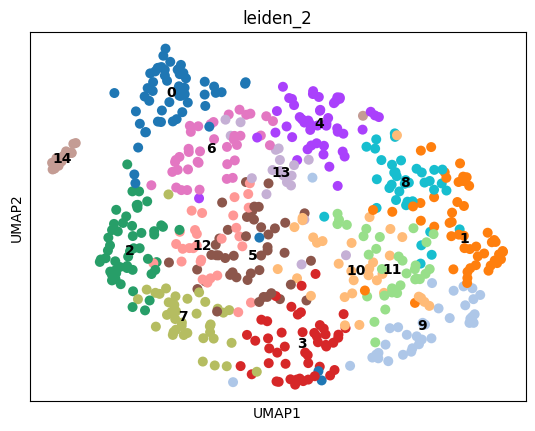

In [25]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

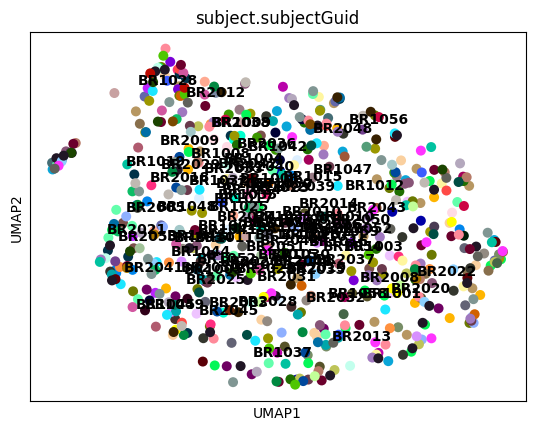

In [26]:
sc.pl.umap(adata, color = 'subject.subjectGuid', legend_loc = 'on data')

### Marker expression

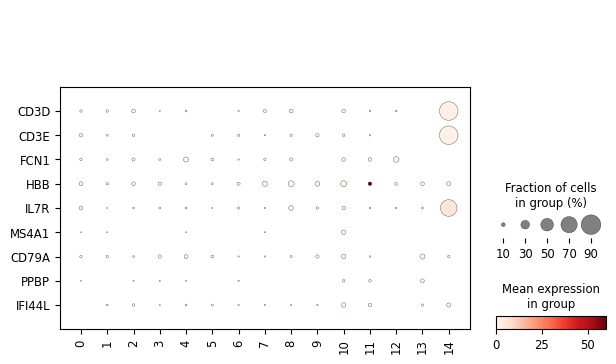

In [27]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

In [28]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     56
1     52
2     51
3     48
4     47
5     45
6     39
7     38
8     38
9     36
10    32
11    32
12    29
13    20
14    18
Name: count, dtype: int64

### Comparison to original labels

In [29]:
adata = add_labels(adata, original_df)

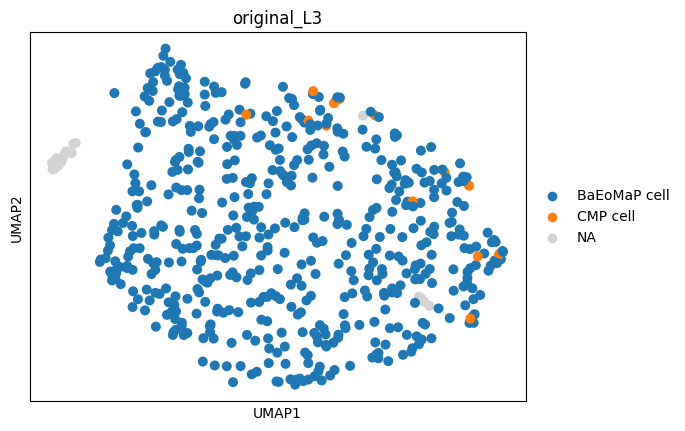

In [30]:
sc.pl.umap(adata, color = 'original_L3')

In [31]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
BaEoMaP cell    545
NaN              22
CMP cell         14
Name: count, dtype: int64

In [32]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
BaEoMaP cell    0.938038
NaN             0.037866
CMP cell        0.024096
Name: count, dtype: float64

### Suggested updates
- Remove CD3D+ cluster (14) as T cell doublet

## Review CLP cell

In [33]:
cell_type = 'CLP cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [34]:
type_uuid

'9c514698-74e8-41fb-8491-915e0e20903f'

In [35]:
adata = read_adata_uuid(type_uuid)

### Clustering

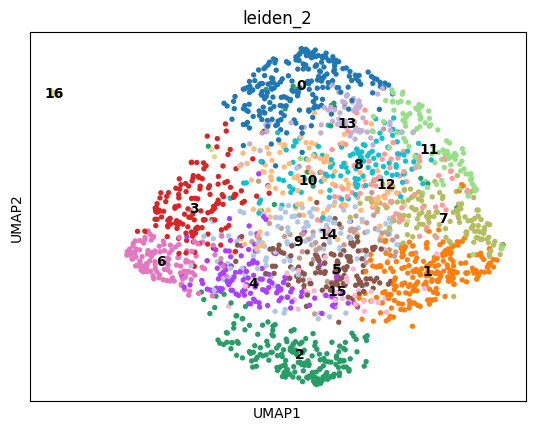

In [36]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

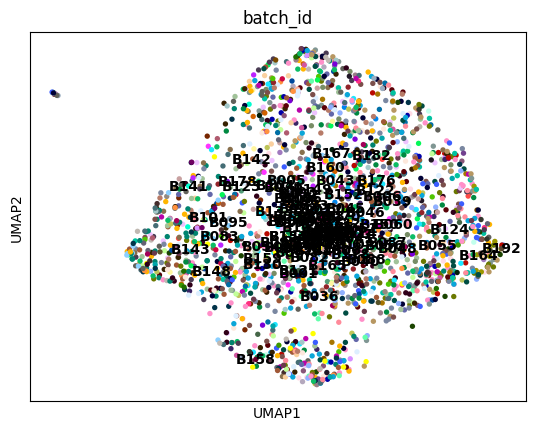

In [37]:
sc.pl.umap(adata, color = 'batch_id', legend_loc = 'on data')

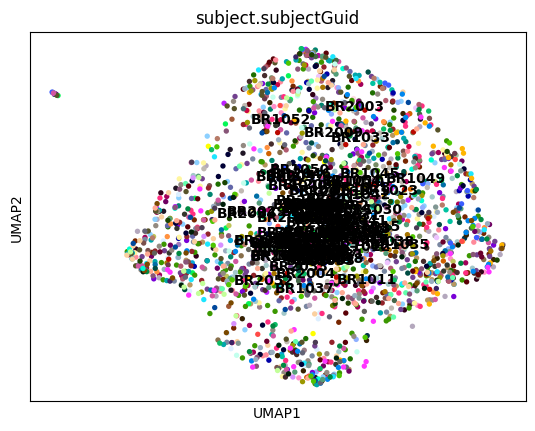

In [38]:
sc.pl.umap(adata, color = 'subject.subjectGuid', legend_loc = 'on data')

### Marker expression

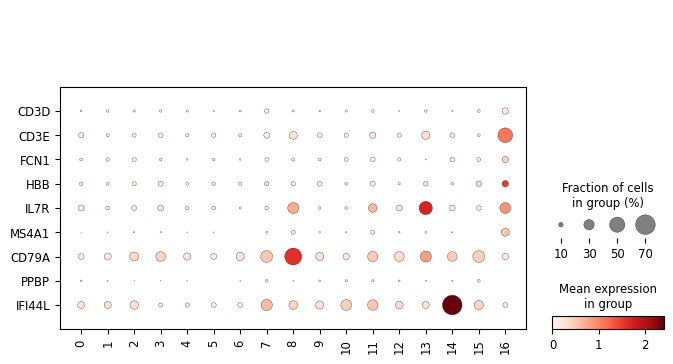

In [39]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

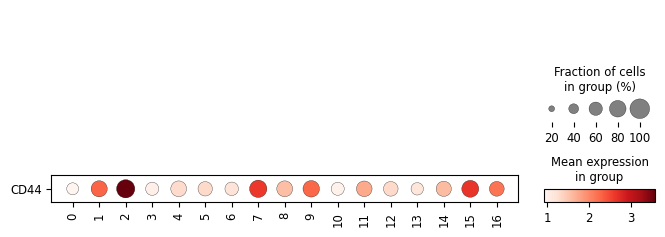

In [40]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

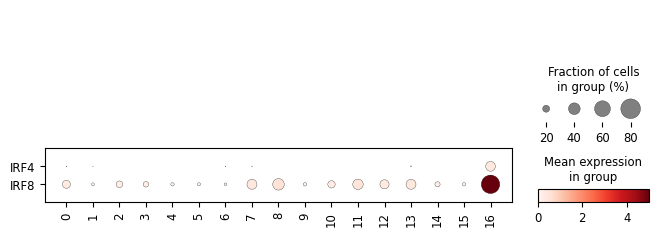

In [41]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = ['IRF4', 'IRF8'], swap_axes = True)

### Cluster counts

In [42]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     231
1     221
2     210
3     143
4     130
5     127
6     125
7     123
8     117
9     116
10    102
11     99
12     80
13     68
14     59
15     39
16     19
Name: count, dtype: int64

### Comparison to original labels

In [43]:
adata = add_labels(adata, original_df)

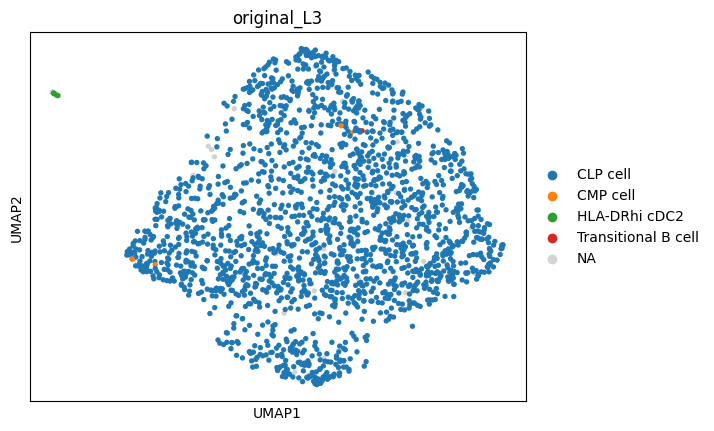

In [44]:
sc.pl.umap(adata, color = 'original_L3')

In [45]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
CLP cell               1958
NaN                      41
HLA-DRhi cDC2             5
CMP cell                  4
Transitional B cell       1
Name: count, dtype: int64

In [46]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
CLP cell               0.974614
NaN                    0.020408
HLA-DRhi cDC2          0.002489
CMP cell               0.001991
Transitional B cell    0.000498
Name: count, dtype: float64

### Suggested updates
- Remove IRF8+ cluster (16) as DC doublet

## Review CMP cell

In [47]:
cell_type = 'CMP cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [48]:
type_uuid

'7dd7e9a7-d6e8-4c59-81d5-ba6404813714'

In [49]:
adata = read_adata_uuid(type_uuid)

### Clustering

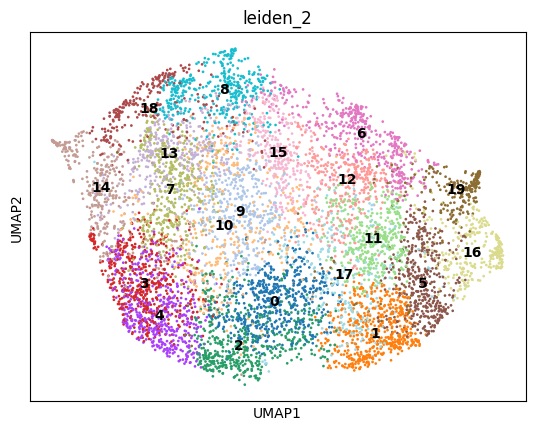

In [50]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

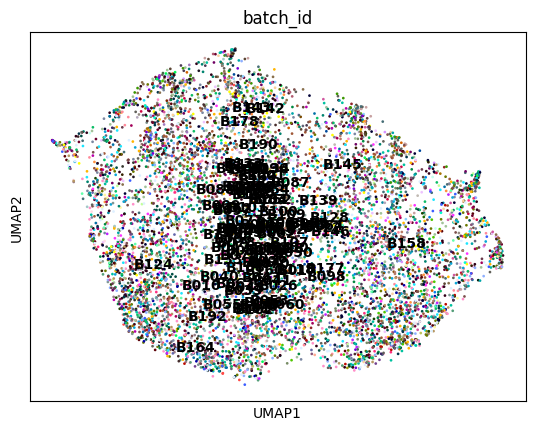

In [51]:
sc.pl.umap(adata, color = 'batch_id', legend_loc = 'on data')

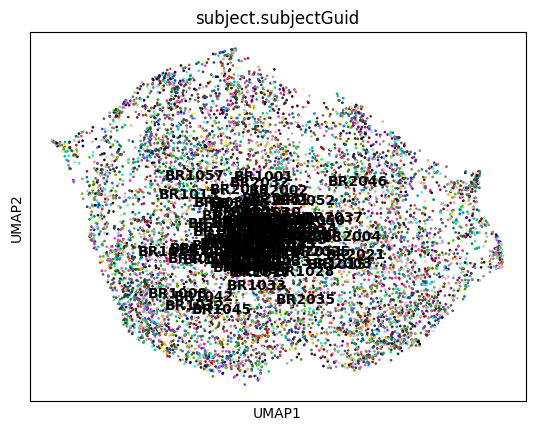

In [52]:
sc.pl.umap(adata, color = 'subject.subjectGuid', legend_loc = 'on data')

### Marker expression

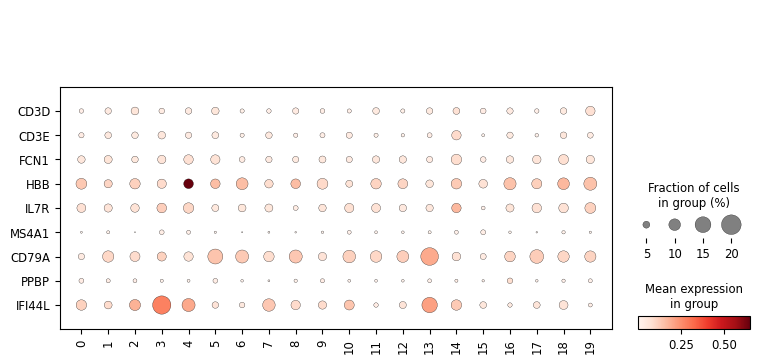

In [53]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

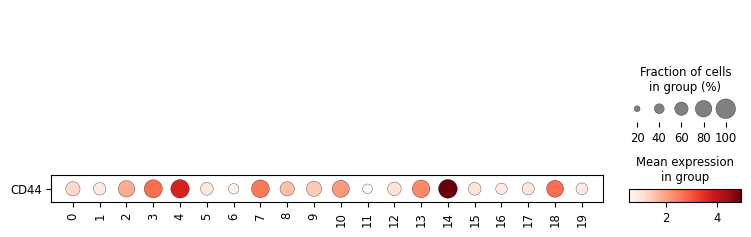

In [54]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

### Cluster counts

In [55]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     541
1     529
2     512
3     501
4     499
5     431
6     431
7     428
8     413
9     396
10    395
11    394
12    352
13    352
14    345
15    312
16    293
17    289
18    258
19    252
Name: count, dtype: int64

### Comparison to original labels

In [56]:
adata = add_labels(adata, original_df)

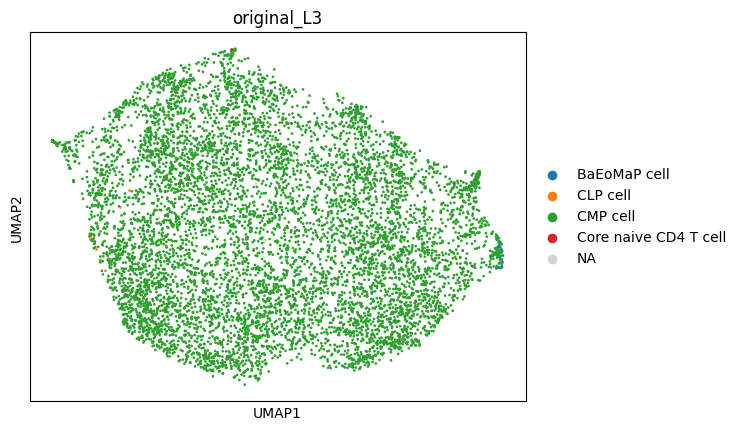

In [57]:
sc.pl.umap(adata, color = 'original_L3')

In [58]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
CMP cell                 7880
NaN                        16
BaEoMaP cell               14
CLP cell                   12
Core naive CD4 T cell       1
Name: count, dtype: int64

In [59]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
CMP cell                 0.994573
NaN                      0.002019
BaEoMaP cell             0.001767
CLP cell                 0.001515
Core naive CD4 T cell    0.000126
Name: count, dtype: float64

### Suggested updates
No changes suggested

## Review Erythrocyte

In [60]:
cell_type = 'Erythrocyte'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [61]:
type_uuid

'315c0b4e-c5ae-48e5-a820-c86a9d368cf5'

In [62]:
adata = read_adata_uuid(type_uuid)

### Clustering

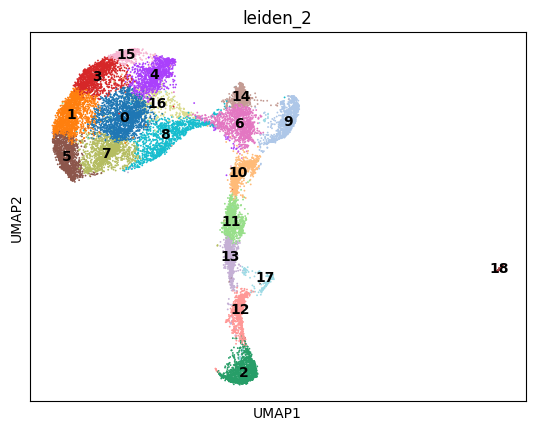

In [63]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

### Marker expression

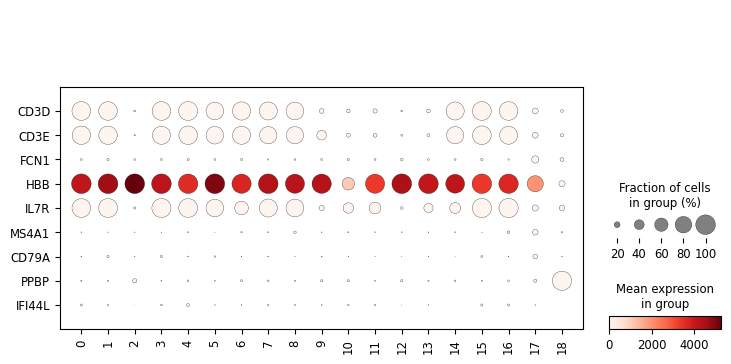

In [64]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

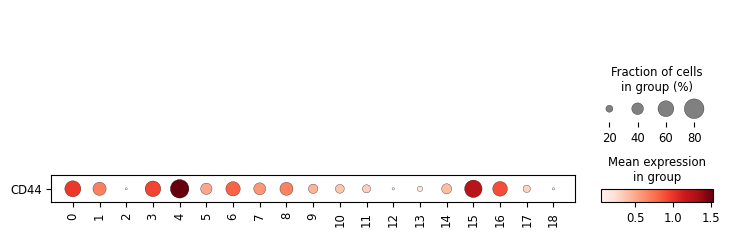

In [65]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

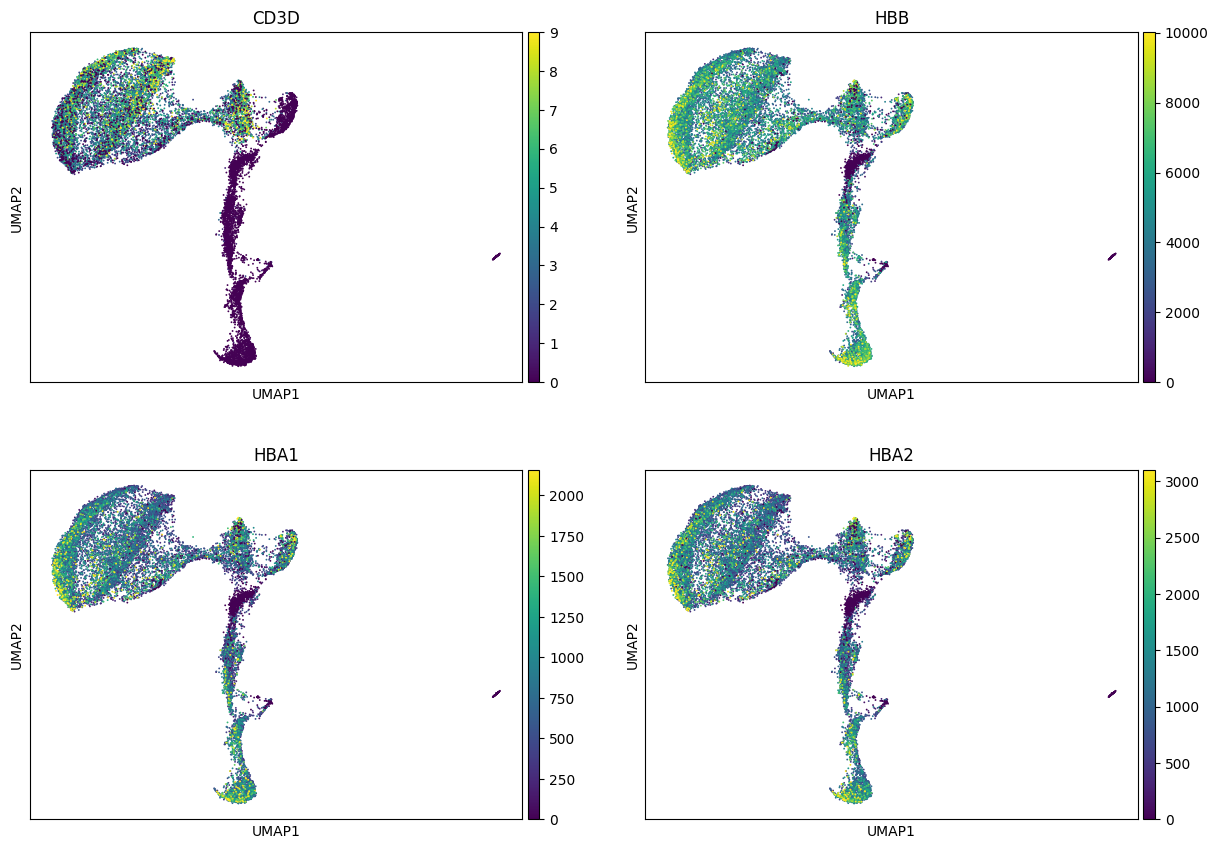

In [66]:
sc.pl.umap(adata, color = ['CD3D','HBB','HBA1','HBA2'], vmax = 'p99', ncols = 2)

### Cluster counts

In [67]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     1808
1     1542
2     1270
3     1241
4     1175
5     1164
6     1100
7     1076
8     1061
9      969
10     873
11     776
12     769
13     676
14     557
15     350
16     310
17     231
18     166
Name: count, dtype: int64

### Comparison to original labels

In [68]:
adata = add_labels(adata, original_df)

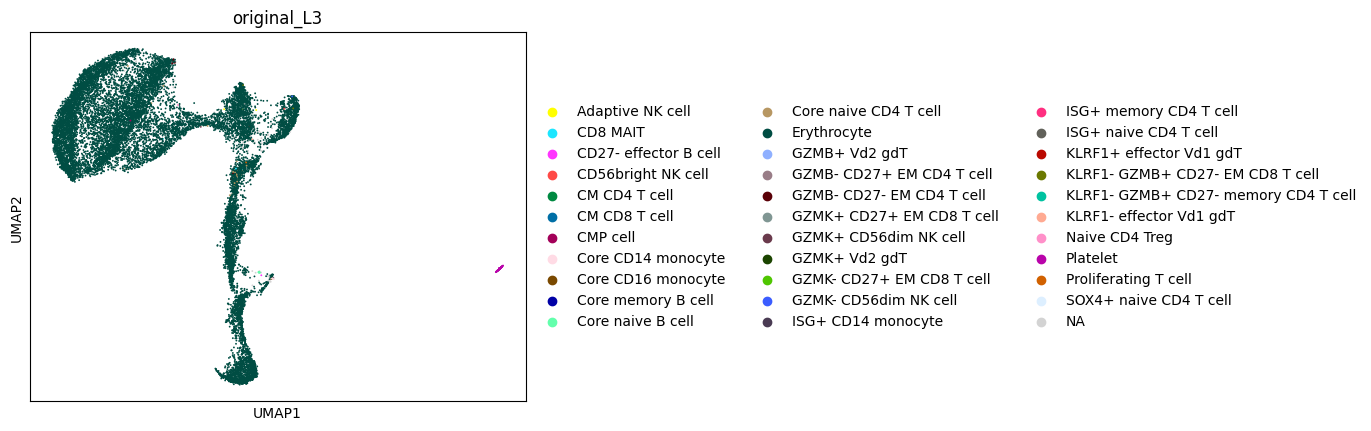

In [69]:
sc.pl.umap(adata, color = 'original_L3')

In [70]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
Erythrocyte                             16351
NaN                                       463
Platelet                                  152
Core naive CD4 T cell                      58
GZMB- CD27- EM CD4 T cell                  14
CD8 MAIT                                    8
Core naive B cell                           7
GZMK+ CD27+ EM CD8 T cell                   6
Core CD14 monocyte                          6
KLRF1- GZMB+ CD27- EM CD8 T cell            5
GZMB- CD27+ EM CD4 T cell                   4
Core CD16 monocyte                          3
Proliferating T cell                        3
GZMK- CD56dim NK cell                       3
GZMB+ Vd2 gdT                               3
Adaptive NK cell                            3
CD56bright NK cell                          2
CM CD4 T cell                               2
CMP cell                                    2
Naive CD4 Treg                              2
KLRF1- effector Vd1 gdT                     2
GZMK+ CD56dim NK cell 

In [71]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
Erythrocyte                             0.955417
NaN                                     0.027054
Platelet                                0.008882
Core naive CD4 T cell                   0.003389
GZMB- CD27- EM CD4 T cell               0.000818
CD8 MAIT                                0.000467
Core naive B cell                       0.000409
GZMK+ CD27+ EM CD8 T cell               0.000351
Core CD14 monocyte                      0.000351
KLRF1- GZMB+ CD27- EM CD8 T cell        0.000292
GZMB- CD27+ EM CD4 T cell               0.000234
Core CD16 monocyte                      0.000175
Proliferating T cell                    0.000175
GZMK- CD56dim NK cell                   0.000175
GZMB+ Vd2 gdT                           0.000175
Adaptive NK cell                        0.000175
CD56bright NK cell                      0.000117
CM CD4 T cell                           0.000117
CMP cell                                0.000117
Naive CD4 Treg                          0.000117
KLRF1- e

### Suggested updates
- Remove PPBP+ cluster (18) as Platelet doublet
- Remove all CD3D+ clusters as T cell doublets?

## Review Platelet

In [72]:
cell_type = 'Platelet'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [73]:
type_uuid

'9361ddcf-b098-49ca-9812-8dd3f3ca7958'

In [74]:
adata = read_adata_uuid(type_uuid)

### Clustering

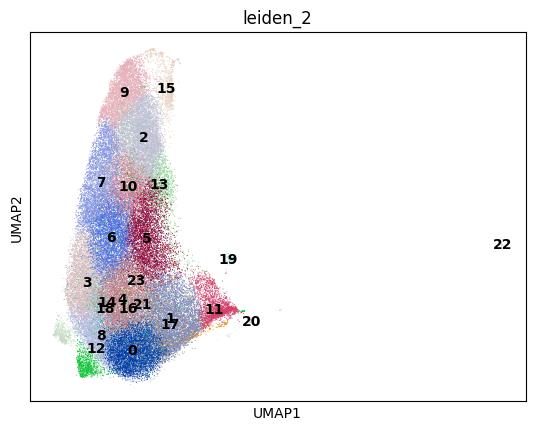

In [75]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

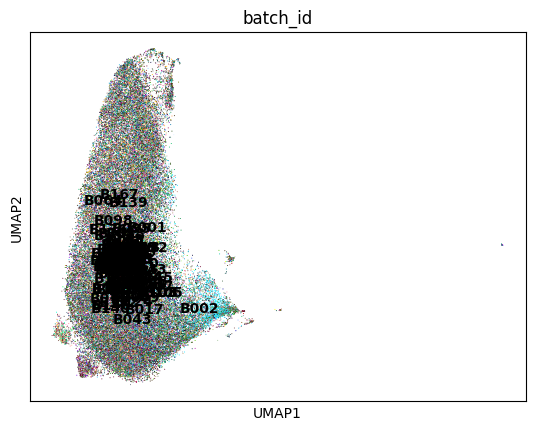

In [76]:
sc.pl.umap(adata, color = 'batch_id', legend_loc = 'on data')

### Marker expression

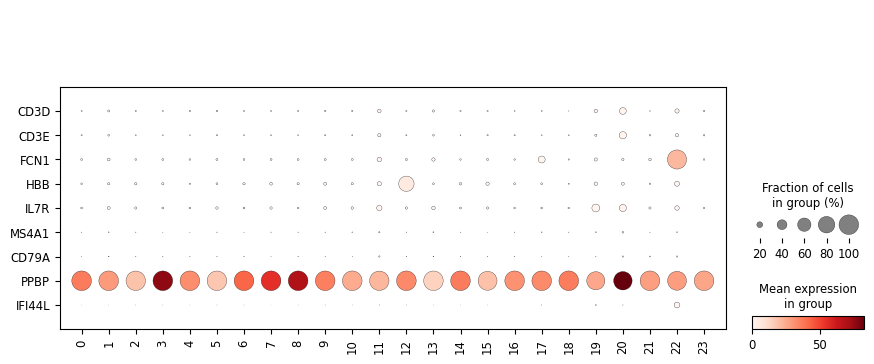

In [77]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

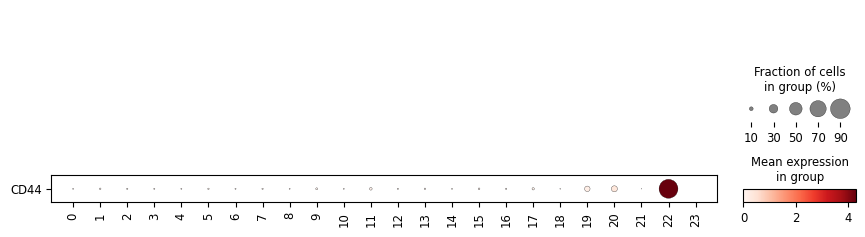

In [78]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

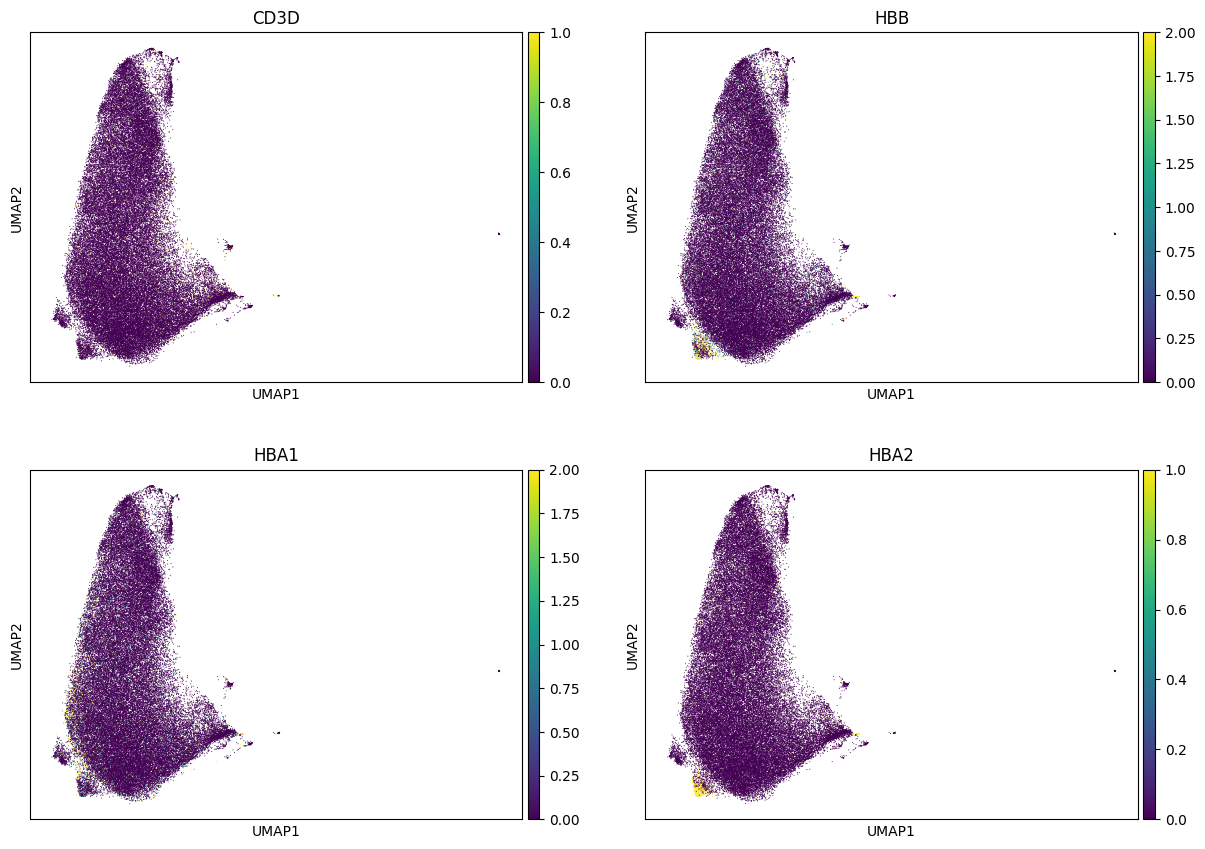

In [79]:
sc.pl.umap(adata, color = ['CD3D','HBB','HBA1','HBA2'], vmax = 'p99', ncols = 2)

### Cluster counts

In [80]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     5927
1     5596
2     5469
3     4670
4     4612
5     4234
6     4108
7     4041
8     3818
9     3786
10    2305
11    2141
12    1722
13    1586
14    1487
15    1137
16     601
17     595
18     568
19     275
20     160
21     150
22     117
23      30
Name: count, dtype: int64

### Outlier investigation

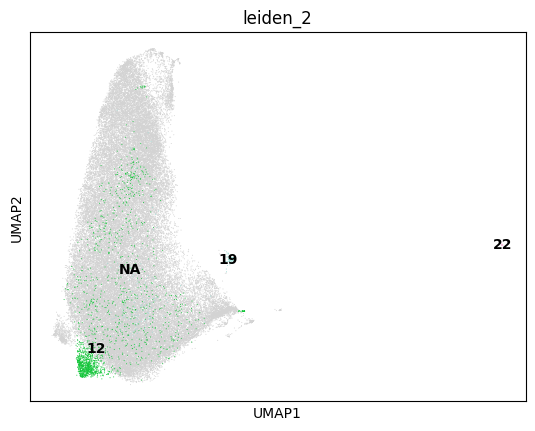

In [81]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data', groups = ['12','19','22'])

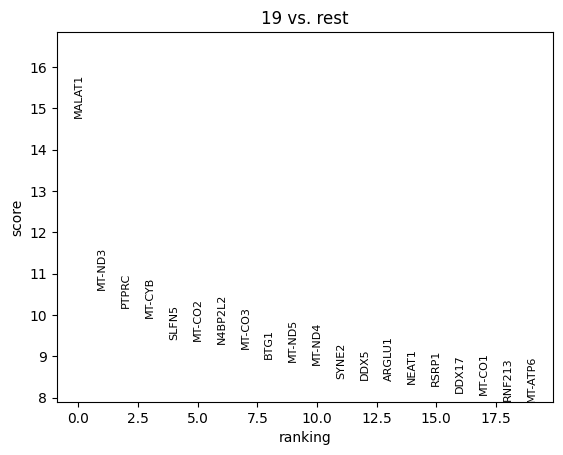

In [82]:
sc.tl.rank_genes_groups(
    adata, 
    groupby = 'leiden_2', 
    groups = ['19']
)
sc.pl.rank_genes_groups(adata, ncols = 2)

### Comparison to original labels

In [83]:
adata = add_labels(adata, original_df)

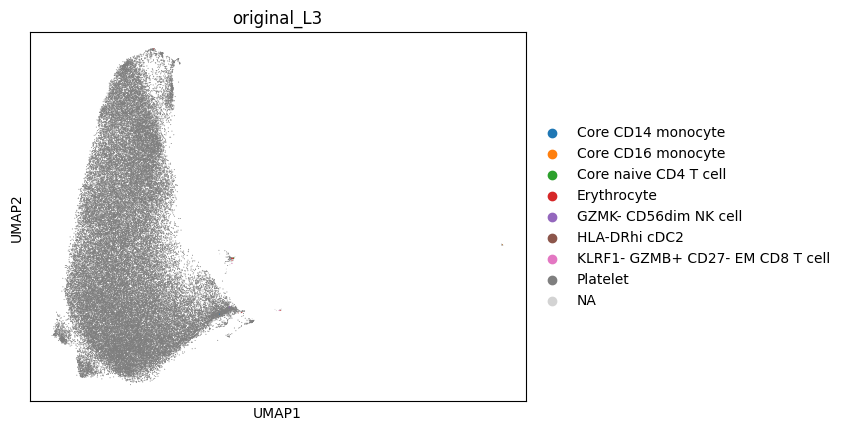

In [84]:
sc.pl.umap(adata, color = 'original_L3')

In [85]:
adata.obs['original_L3'].value_counts(dropna = False)

original_L3
Platelet                            58734
NaN                                   380
Erythrocyte                             9
Core naive CD4 T cell                   4
Core CD14 monocyte                      2
GZMK- CD56dim NK cell                   2
KLRF1- GZMB+ CD27- EM CD8 T cell        2
Core CD16 monocyte                      1
HLA-DRhi cDC2                           1
Name: count, dtype: int64

In [86]:
adata.obs['original_L3'].value_counts(dropna = False) / adata.obs.shape[0]

original_L3
Platelet                            0.993219
NaN                                 0.006426
Erythrocyte                         0.000152
Core naive CD4 T cell               0.000068
Core CD14 monocyte                  0.000034
GZMK- CD56dim NK cell               0.000034
KLRF1- GZMB+ CD27- EM CD8 T cell    0.000034
Core CD16 monocyte                  0.000017
HLA-DRhi cDC2                       0.000017
Name: count, dtype: float64

### Suggested updates
- Remove HBB+ cluster (12) as Erythrocyte doublet
- Remove FCN1+ cluster (22) as Myeloid doublet